In [1]:
from dataset.dataset import TrainDataLoader
from models.siamese import SiameseRPNpp
from models.siameserpn_alex import SiameseRPN

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import os
import tqdm
import random
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [2]:
class MultiBoxLoss(nn.Module):
    def __init__(self):
        super(MultiBoxLoss, self).__init__()

    def forward(self, predictions, targets):
#         print('+++++++++++++++++++++++++++++++++++++++++++++++++++')
        cout, rout = predictions
        """ class """
        class_pred, class_target = cout, targets[:, 0].long()
        pos_index , neg_index    = list(np.where(class_target.cpu() == 1)[0]), list(np.where(class_target.cpu() == 0)[0])
        pos_num, neg_num         = len(pos_index), len(neg_index)
       
        class_pred, class_target = class_pred[pos_index + neg_index], class_target[pos_index + neg_index]

        closs = F.cross_entropy(class_pred, class_target, size_average=False, reduce=False)
        closs = torch.div(torch.sum(closs), 64)

        """ regression """
        reg_pred = rout
        reg_target = targets[:, 1:]
        rloss = F.smooth_l1_loss(reg_pred, reg_target, size_average=False, reduce=False) #3125, 4
        rloss = torch.div(torch.sum(rloss, dim = 1), 4)
        rloss = torch.div(torch.sum(rloss[pos_index]), 16)

        loss = closs + rloss
        return closs, rloss, loss, reg_pred, reg_target, pos_index, neg_index

def adjust_learning_rate(lr, optimizer, epoch, gamma=0.1):
    """Sets the learning rate to the initial LR decayed 0.9 every 50 epochs"""
    lr = lr * (0.9 ** (epoch // 1))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


## Dataset Loading

In [35]:
root = 'D:\\datasets\\TargetBoxDatasets\\YoutubeBoundingBoxes\\videos\\boudingboxes_detection\\frames'
dataset = TrainDataLoader(root,out_feature=25)

## Training 

In [253]:
weight_dir = 'checkpoint'

#Hyperparameters 
lr = 0.001
momentum = 0.9
weight_decay = 5e-5
max_epochs = 2
max_batches = 10
steps = 1

start = 0 # in case we're resuming training 
steps_save = 5 # nb of epochs to save model
steps_report = 100 # nb of steps to report loss

In [254]:
torch.cuda.empty_cache()

In [256]:
# Initialize model with pretrained weights : 
model = SiameseRPNpp(anchor=5)
model = model.cuda()
cudnn.benchmark = True
# Loss and optimizer
criterion= MultiBoxLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay = weight_decay)


Loading pretrained model weights


In [258]:
def save(it):
    model_path = os.path.join('checkpoint', f'model_{str(it).zfill(5)}.pth')
    
    opt_path = os.path.join('checkpoint', f'opt_{str(it).zfill(5)}.pth')
    print(f'\nsaving model to {model_path} ...')
        
    torch.save({'model': model.state_dict()}, model_path)
    torch.save({'epoch': epoch,
                'iteration': it,
                'optimG': optimizer.state_dict()}, opt_path)
                    
                    
    os.system('echo {} > {}'.format(str(it).zfill(5),
                                            os.path.join('checkpoint', 'latest.ckpt')))
    if it > 0 : 
        print('Removing files :', os.path.join('checkpoint', f'model_{str(it-steps_save).zfill(5)}.pth'))
        
        os.remove(os.path.join('checkpoint', f'model_{str(it-steps_save).zfill(5)}.pth'))
        os.remove(os.path.join('checkpoint', f'opt_{str(it-steps_save).zfill(5)}.pth'))

In [259]:
%%time
closses, rlosses, tlosses = AverageMeter(), AverageMeter(), AverageMeter()
summary_loss = {'closs':[], 'rloss':[], 'tloss':[]}
if start == 0 : 
    previous_epoch = -1
else : 
    previous_epoch = start
for epoch in range(start, max_epochs):
    cur_lr = adjust_learning_rate(lr, optimizer, epoch, gamma=0.1) # adjust learning rate
    epoch_closs = []
    epoch_rloss = []
    epoch_tloss = []
    for idx in range(dataset.__len__()): 
        ret = dataset.__get__(idx)
        template = ret['template_tensor'].cuda()
        detection= ret['detection_tensor'].cuda()
        pos_neg_diff = ret['pos_neg_diff_tensor'].cuda()
        
        rout, cout = model(template, detection)
        # reshape model output to fit the loss
        cout = cout.squeeze().permute(1,2,0).reshape(-1, 2)
        rout = rout.squeeze().permute(1,2,0).reshape(-1, 4)
        
        # get labels
        predictions, targets = (cout, rout), pos_neg_diff
        
        # get multi box loss
        closs, rloss, loss, reg_pred, reg_target, pos_index, neg_index = criterion(predictions, targets)
       
        closs_ = closs.cpu().item() # transfer to cpu
        rloss_ = rloss.cpu().item()
        loss_ = loss.cpu().item()
        
        epoch_closs.append(closs_)
        epoch_rloss.append(rloss_)
        epoch_tloss.append(loss_)
        
        if np.isnan(closs_):
            print('Error, loss is nan')
            break
        
        closses.update(closs_)
        rlosses.update(rloss_)
        tlosses.update(loss_)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        steps += 1
        
        if epoch % steps_save == 0 and epoch != previous_epoch:
#             file_path = os.path.join(weight_dir, 'weights-{:07d}.pth.tar'.format(steps))
#             state = {
#             'epoch' :epoch+1,
#             'state_dict' :model.state_dict(),
#             'optimizer' : optimizer.state_dict(),
#             }
#             torch.save(state, file_path)
            save(epoch)
            previous_epoch = epoch 
        if steps % steps_report == 0: 
            print(f'Epoch {epoch}/{max_epochs}, example {idx}/{dataset.__len__()} :  closs={closs_}, rloss={rloss_}, tloss={loss_}')
    summary_loss['closs'].append(epoch_closs)
    summary_loss['rloss'].append(epoch_rloss)
    summary_loss['tloss'].append(epoch_tloss)

C:\Users\Yassir\miniconda3\envs\venv2\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))



saving model to checkpoint\model_00000.pth ...
Epoch 0/2, example 98/354 :  closs=0.8424288034439087, rloss=0.6617850065231323, tloss=1.504213809967041
Epoch 0/2, example 198/354 :  closs=0.5232793092727661, rloss=0.05855277180671692, tloss=0.5818320512771606
Epoch 0/2, example 298/354 :  closs=0.3845022916793823, rloss=0.024797409772872925, tloss=0.40929970145225525
Epoch 1/2, example 44/354 :  closs=0.23833809792995453, rloss=0.24619342386722565, tloss=0.4845315217971802
Epoch 1/2, example 144/354 :  closs=0.23092828691005707, rloss=0.0, tloss=0.23092828691005707
Epoch 1/2, example 244/354 :  closs=0.4312514066696167, rloss=0.08636952936649323, tloss=0.5176209211349487
Epoch 1/2, example 344/354 :  closs=0.16610080003738403, rloss=0.012361906468868256, tloss=0.17846271395683289
Wall time: 2min 1s


In [67]:
closs_mean = np.array(summary_loss['closs']).mean(axis=1)
rloss_mean = np.array(summary_loss['rloss']).mean(axis=1)
tloss_mean = np.array(summary_loss['tloss']).mean(axis=1)

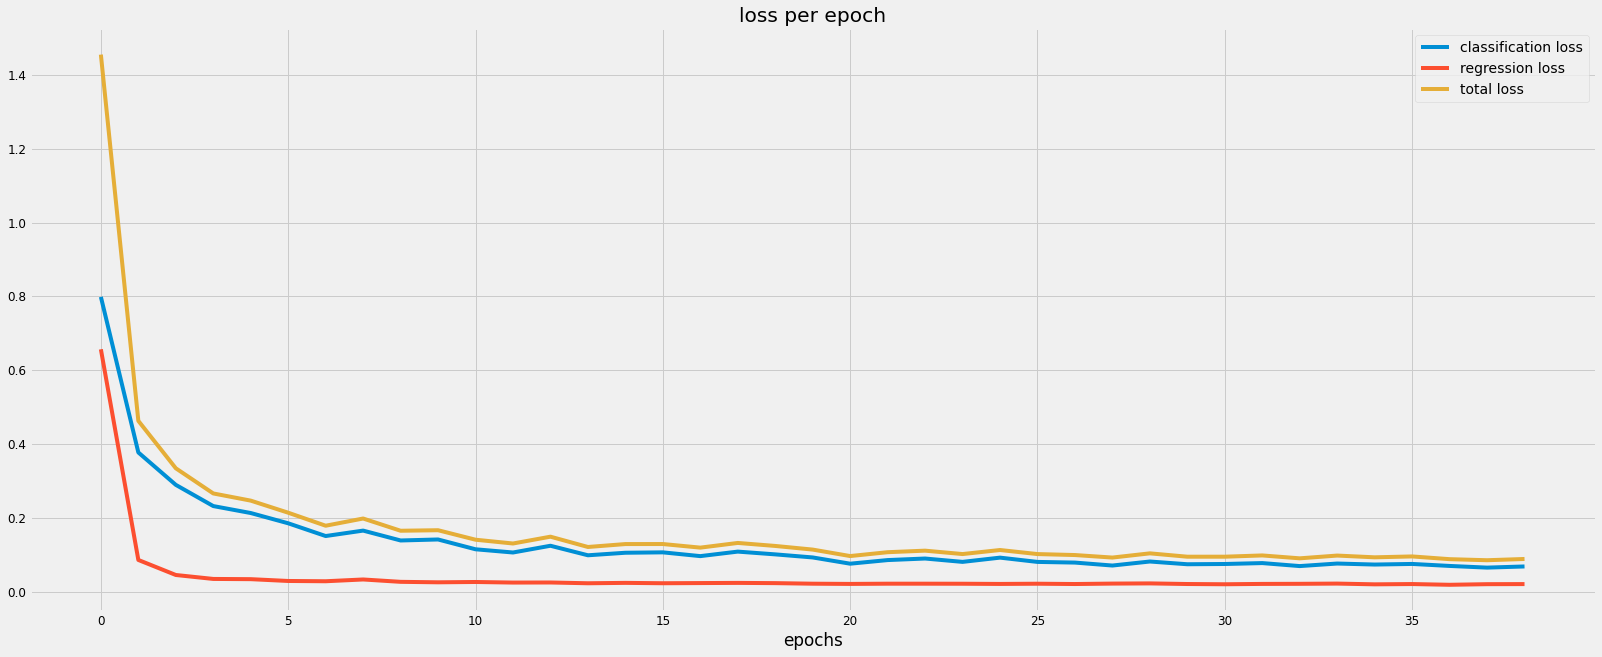

In [70]:

plt.plot(closs_mean, label='classification loss')
plt.plot(rloss_mean, label='regression loss')
plt.plot(tloss_mean, label='total loss')
plt.title('loss per epoch')
plt.xlabel('epochs')
plt.legend()

In [11]:
_ = model.eval()

In [196]:
# for c in range(20):
#     channel_1 = rout[0][c].cpu().detach()
#     ax = sns.heatmap(channel_1, linewidth=0, cmap="jet")
#     plt.show()

## Test

In [197]:
# dataset = TrainDataLoader(root,out_feature=25)

In [241]:
%%time
import time
times = []
start = time.time()


index_list = range(dataset.__len__())
ret = dataset.__get__(random.choice(index_list)) 
template = ret['template_tensor'].cuda()
detection= ret['detection_tensor'].cuda()
pos_neg_diff = ret['pos_neg_diff_tensor'].cuda()

rout, cout  = model(template, detection) #[1, 10, 17, 17], [1, 20, 17, 17]

cout = cout.reshape(-1, 2)
rout = rout.reshape(-1, 4)
cout_ = cout.cpu().detach().numpy()
score = 1/(1 + np.exp(cout_[:,1]-cout_[:,0]))
diff   = rout.cpu().detach().numpy() #1445

num_proposals = 10


end_time = time.time()-start
times.append(end_time)
    

Wall time: 84.1 ms


In [242]:
# best_labels = np.argsort(pos_neg_diff.cpu().detach().numpy()[:,0])[::-1][:10]

In [243]:
score = F.softmax(cout).cpu().detach().numpy()[:,1]

score_64_index = np.argsort(score)[::-1][:num_proposals]
score64 = score[score_64_index]
diffs64 = diff[score_64_index, :]#pos_neg_diff.cpu().detach().numpy()[best_labels,1:] #diff[score_64_index, :]
anchors64 = ret['anchors'][score_64_index]


proposals_x = (anchors64[:, 0] + anchors64[:, 2] * diffs64[:, 0]).reshape(-1, 1)
proposals_y = (anchors64[:, 1] + anchors64[:, 3] * diffs64[:, 1]).reshape(-1, 1)
proposals_w = (anchors64[:, 2] * np.exp(diffs64[:, 2])).reshape(-1, 1)
proposals_h = (anchors64[:, 3] * np.exp(diffs64[:, 3])).reshape(-1, 1)

# proposals_x = anchors64[:,0].reshape(-1, 1)
# proposals_y = anchors64[:,1].reshape(-1, 1)
# proposals_w = anchors64[:,2].reshape(-1, 1)
# proposals_h = anchors64[:,3].reshape(-1, 1)

proposals = np.hstack((proposals_x, proposals_y, proposals_w, proposals_h))



<ipython-input-243-b2c933f6f040>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  score = F.softmax(cout).cpu().detach().numpy()[:,1]


In [244]:
detection = ret['detection_cropped_resized']
template = ret['template_cropped_resized']

In [245]:
detection = ret['detection_tensor'].cpu().detach().numpy()

In [246]:
detection = Image.open(ret['detection_img_path'])

In [247]:
# pos_neg_diff_cpu = pos_neg_diff.cpu().numpy()
# num_proposals = 50
# score_64_index =  np.argsort(score)[::-1][:num_proposals]#np.array([1492])

# diffs64 = pos_neg_diff_cpu[score_64_index,1:]
# score64 = score[score_64_index]

# anchors64 = ret['anchors'][score_64_index]
# proposals_x = (anchors64[:, 0] + anchors64[:, 2] * diffs64[:, 0]).reshape(-1, 1)
# proposals_y = (anchors64[:, 1] + anchors64[:, 3] * diffs64[:, 1]).reshape(-1, 1)
# proposals_w = (anchors64[:, 2] * np.exp(diffs64[:, 2])).reshape(-1, 1)
# proposals_h = (anchors64[:, 3] * np.exp(diffs64[:, 3])).reshape(-1, 1)
# proposals = np.hstack((proposals_x, proposals_y, proposals_w, proposals_h))


In [248]:
from PIL import Image, ImageOps, ImageStat, ImageDraw

draw = ImageDraw.Draw(detection)
for i in range(num_proposals):
    x, y, w, h = proposals_x[i], proposals_y[i], proposals_w[i], proposals_h[i]
    print(x, y, w, h)
    x1, y1, x2, y2 = x-w//2, y-h//2, x+w//2, y+h//2
    draw.line([(x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)], width=1, fill='red')
""" save detection template proposals"""
x, y, w, h = ret['detection_target_xywh']
print(x, y, w, h)
x1, y1, x2, y2 = x-w//2, y-h//2, x+w//2, y+h//2
draw.line([(x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)], width=1, fill='green')


[239.24577] [102.92134] [5.4069] [19.321667]
[273.8459] [3.5415344] [2.672035] [11.251916]
[6.039112] [259.17368] [65.16129] [50.132248]
[188.28923] [166.42047] [8.681947] [27.62688]
[84.69284] [264.23773] [72.50988] [66.69582]
[112.732] [172.68657] [9.68177] [30.90906]
[33.751217] [156.35524] [8.152117] [25.549328]
[177.06685] [436.59872] [150.99287] [165.23497]
[260.66678] [447.229] [140.42978] [131.81169]
[255.03035] [126.83673] [6.7706842] [19.885681]
175.0 159.0 91.0 189.0


(-0.5, 254.5, 254.5, -0.5)

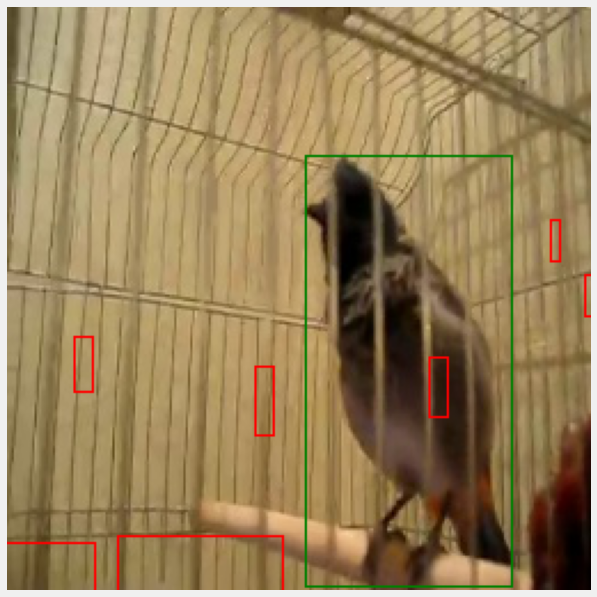

In [252]:
import matplotlib.pyplot as plt
plt.imshow(detection)
plt.axis('off')


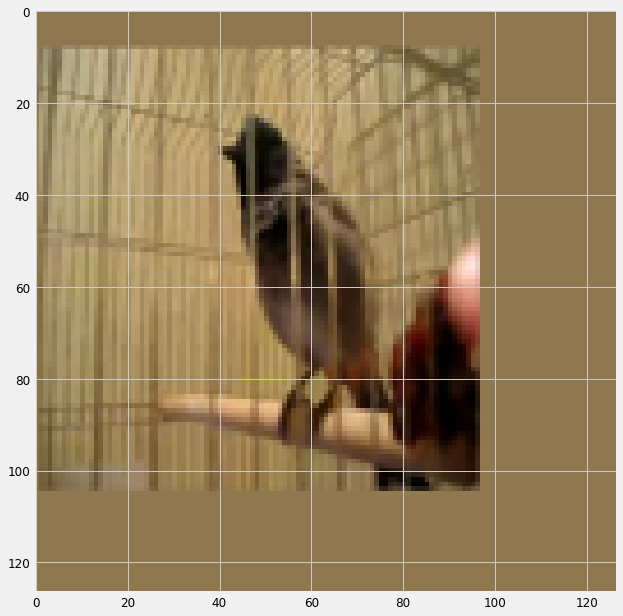

In [250]:
plt.imshow(template)